# Vehicle Detection

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## HOG feature extraction

The first step is to implement a HOG feature extraction and run it against a set of images. Also, we need a extract_features function to be used later. Code for both of these functions is based on Chapter 29 of this lessson.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Testing

Let's open some random images and see what the HOG result and feature results contain.

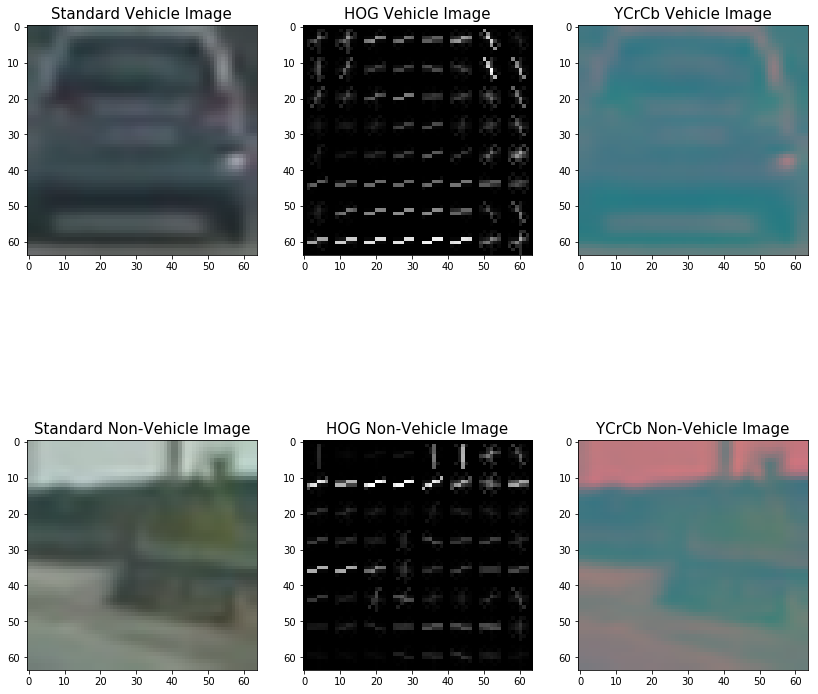

In [2]:
vehicle = mpimg.imread('data/vehicles/GTI_Far/image0010.png')
non_vehicle = mpimg.imread('data/non-vehicles/GTI/image10.png')

_, hog_vehicle = get_hog_features(vehicle[:,:,2], orient=9, pix_per_cell=8, cell_per_block=8, vis=True)
_, hog_non_vehicle = get_hog_features(non_vehicle[:,:,2], orient=9, pix_per_cell=8, cell_per_block=8, vis=True)

ycrcb_vehicle = cv2.cvtColor(vehicle, cv2.COLOR_RGB2YCrCb)
ycrcb_non_vehicle = cv2.cvtColor(non_vehicle, cv2.COLOR_RGB2YCrCb)

f, ((image1, image2, image3), (image4, image5, image6)) = plt.subplots(2, 3, figsize=(14, 14))
image1.imshow(vehicle)
image1.set_title('Standard Vehicle Image', fontsize=15)
image2.imshow(hog_vehicle, cmap='gray')
image2.set_title('HOG Vehicle Image', fontsize=15)
image3.imshow(ycrcb_vehicle)
image3.set_title('YCrCb Vehicle Image', fontsize=15)
image4.imshow(non_vehicle)
image4.set_title('Standard Non-Vehicle Image', fontsize=15)
image5.imshow(hog_non_vehicle, cmap='gray')
image5.set_title('HOG Non-Vehicle Image', fontsize=15)
image6.imshow(ycrcb_non_vehicle)
image6.set_title('YCrCb Non-Vehicle Image', fontsize=15)

## Training the classification algorithm

Now that we have our functions set up and we have tested against a single set of images, it's time to load all images, extract features and train the classification algorithm. This code is also based on Chapter 29 from this lesson, and the following workflow is defined:

1. Image loading
2. Feature extraction
3. Array stack for feature vectors + label vector initialization
4. Data splitting
5. SVC definition and fit (patience, it might take a little bit on a slower CPU).

In [3]:
# Load all images
print('Loading images')
vehicles = glob.glob('data/vehicles/**/*.png')
non_vehicles = glob.glob('data/non-vehicles/**/*.png')

### Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

print('Extracting features')
car_features = extract_features(vehicles, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,hog_channel=hog_channel)

notcar_features = extract_features(non_vehicles, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block,hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Loading images
Extracting features
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9825


# Sliding-window technique for car detection

Now it's time to implement car detection using the sliding-window technique. Code for this block is based on Chapter 35 of this lesson.

## Aux. functions

In [14]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2RGB':
        return img

    
# If a positive is detected, draw multiple scaled boxes.
def positive_box(img, limits=720, scales=[1.0,1.2,1.4,1.5,1.6,2.0,2.5,3.0,3.5,5.0]):
    boxes=[]
    
    for i in range(len(scales)):
        box = find_cars(img, ystop=[360,limits], scale=scales[i])
        boxes = boxes+box
    
    return boxes

# Returns heatmap and final image
def heatmap_box(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    #initialize the heat image to all zero values with a size similar to our image
    bboxes = positive_box(image)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list=bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 9)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return heat,draw_img

# Draws the actual box
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



## Find_cars pipeline

The code below contains a helper function that will assist with the workflow.

In [5]:
def find_cars(img, ystart=[380,1280], ystop=[360,720], scale=1.5, pix_per_cell=8, cell_per_block=2, orient=9, scv=svc):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystop[0]:ystop[1],ystart[0]:ystart[1],:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = img_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    predictions = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            # subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            # spatial_features = bin_spatial(subimg, size=spatial_size)
            # hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                predictions.append(((xbox_left+ystart[0], ytop_draw+ystop[0]),
                              (xbox_left+win_draw+ystart[0],ytop_draw+win_draw+ystop[0])))
                
    return predictions

## Draw windows with positive detections

At this point, we should encounter an image with several false positives:

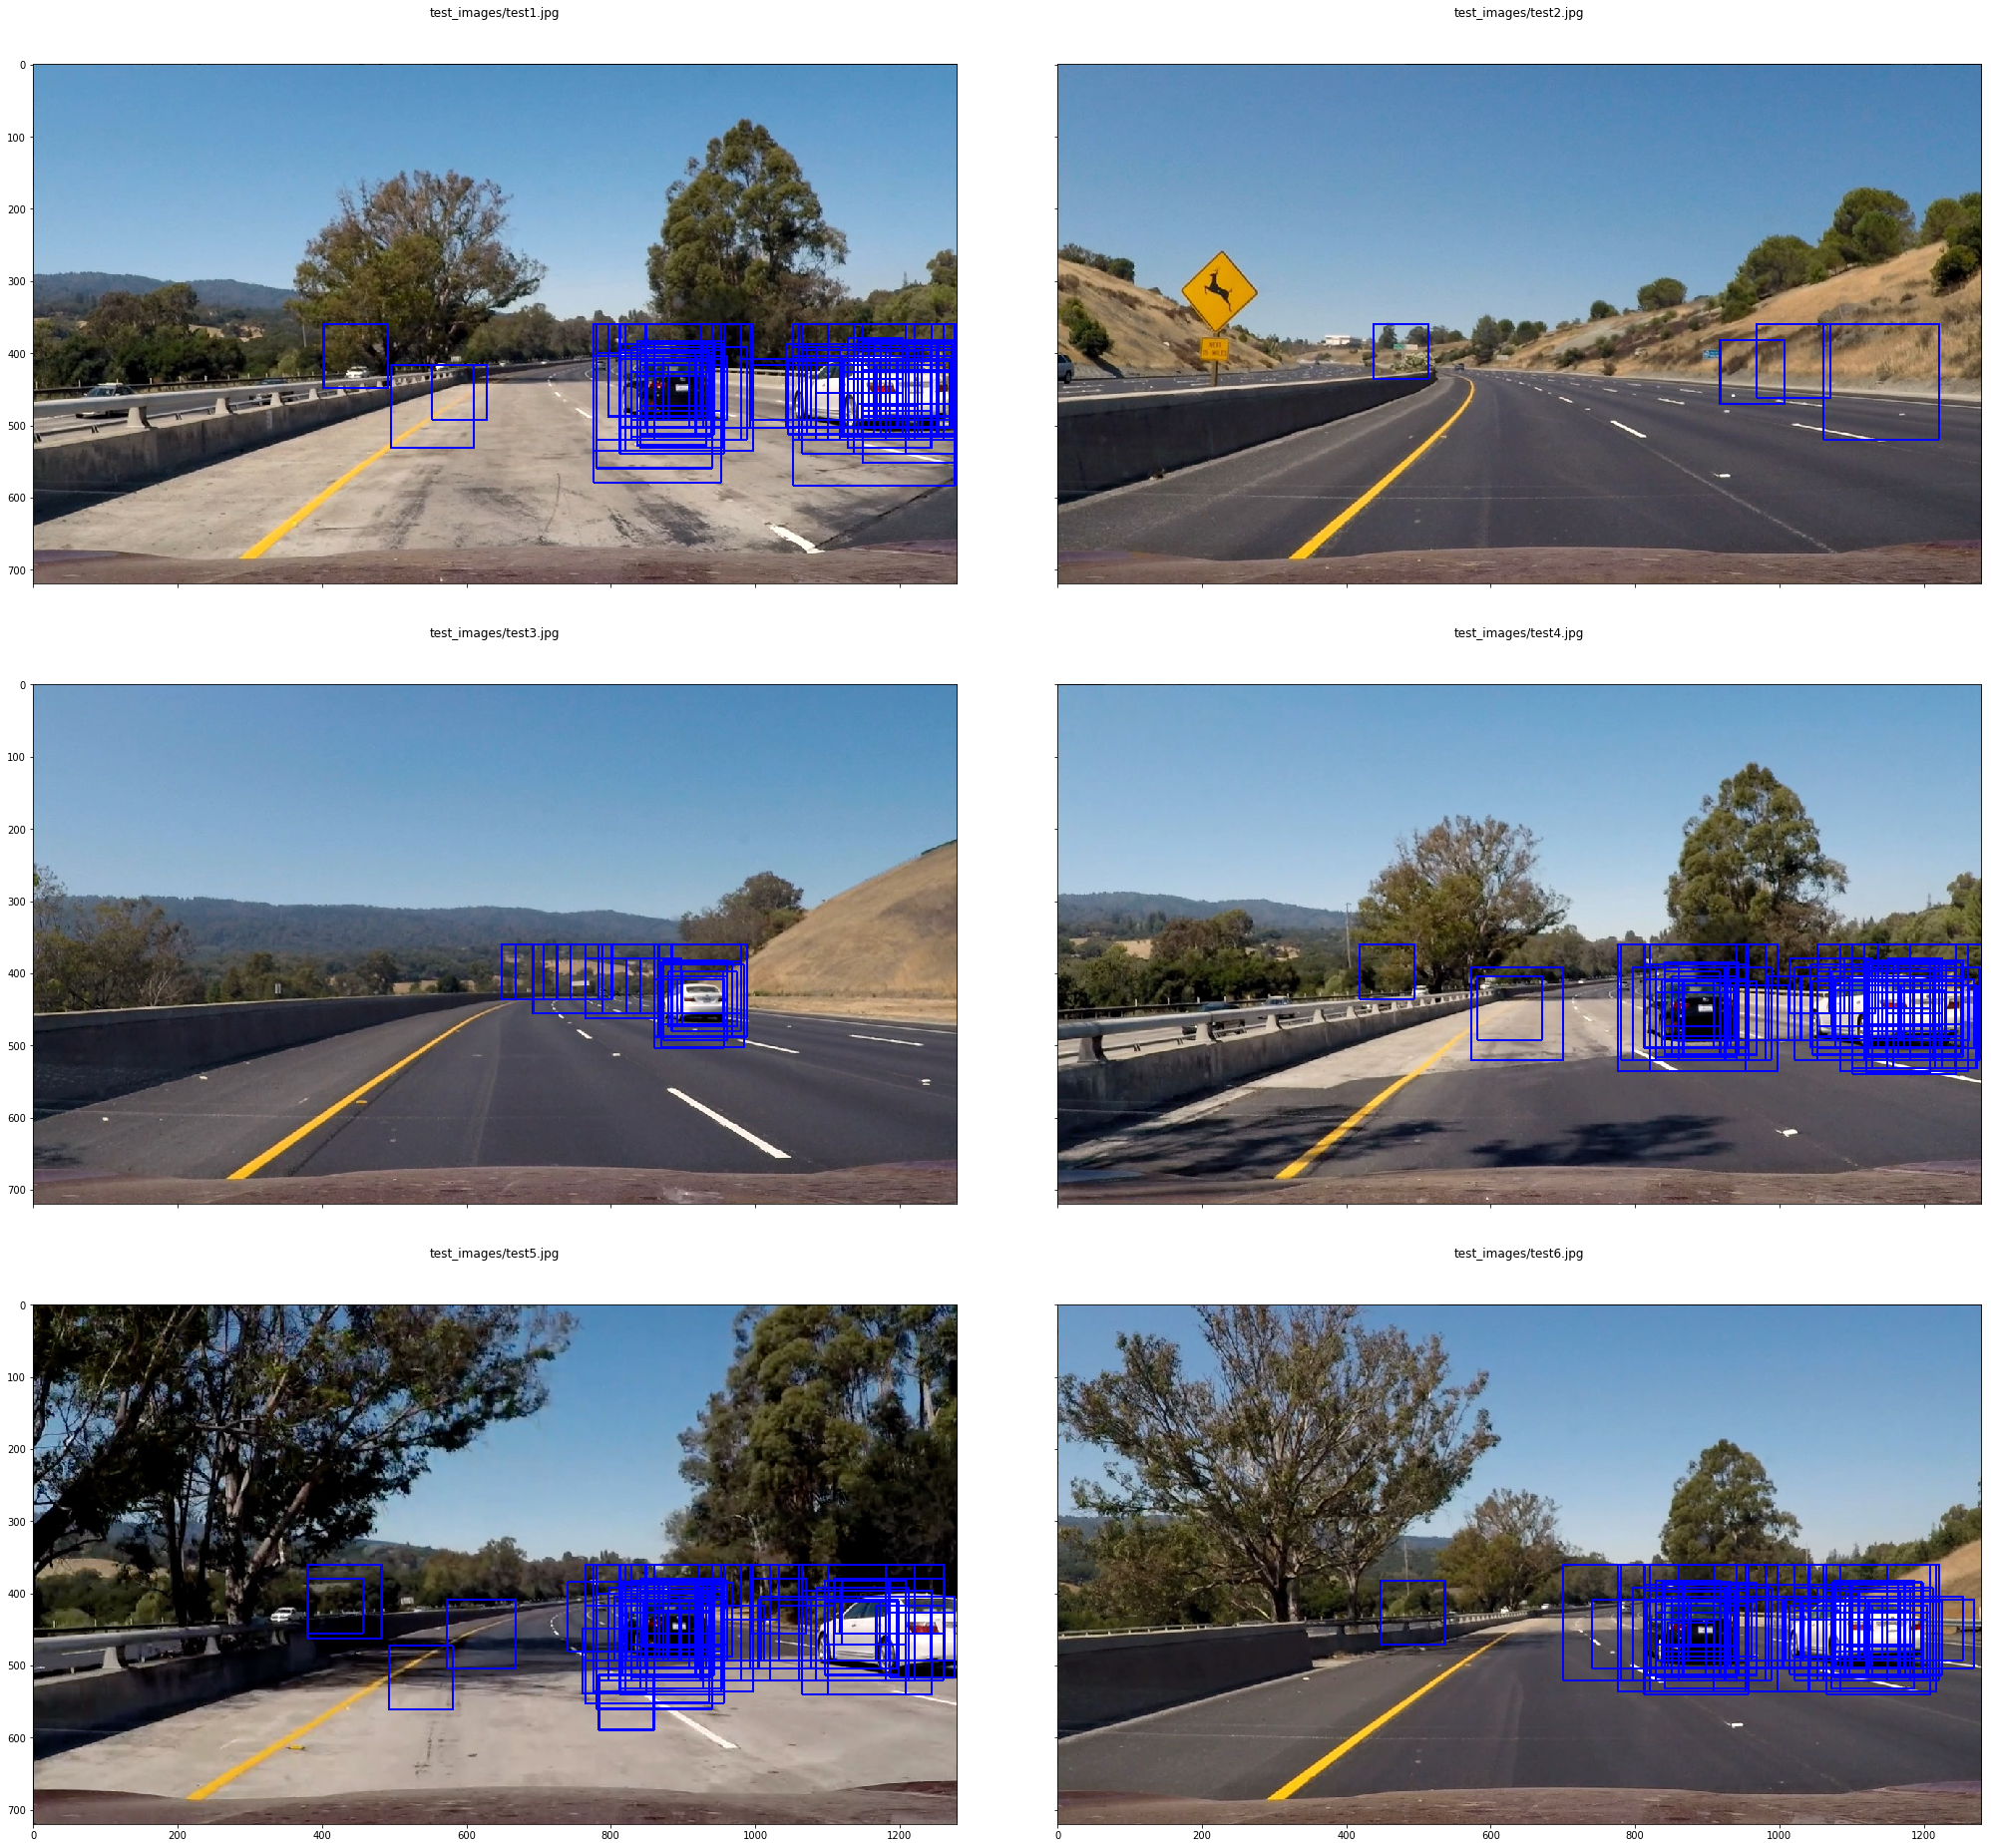

In [6]:
images = glob.glob('test_images/test*.jpg')

figure = plt.figure(1, (35., 35.))
rows = 3
cols = 2
i = 0
image_grid = ImageGrid(figure, 111, nrows_ncols=(rows, cols), axes_pad=1.4)

for fname in images:
    img = mpimg.imread(fname)
    
    image_grid[i].set_title(fname, y=1.08)
    image_grid[i].imshow(draw_boxes(img,positive_box(img),thick=2))
    i = i + 1
    
plt.show()

If we apply heatmap techniques we should improve results significantly.

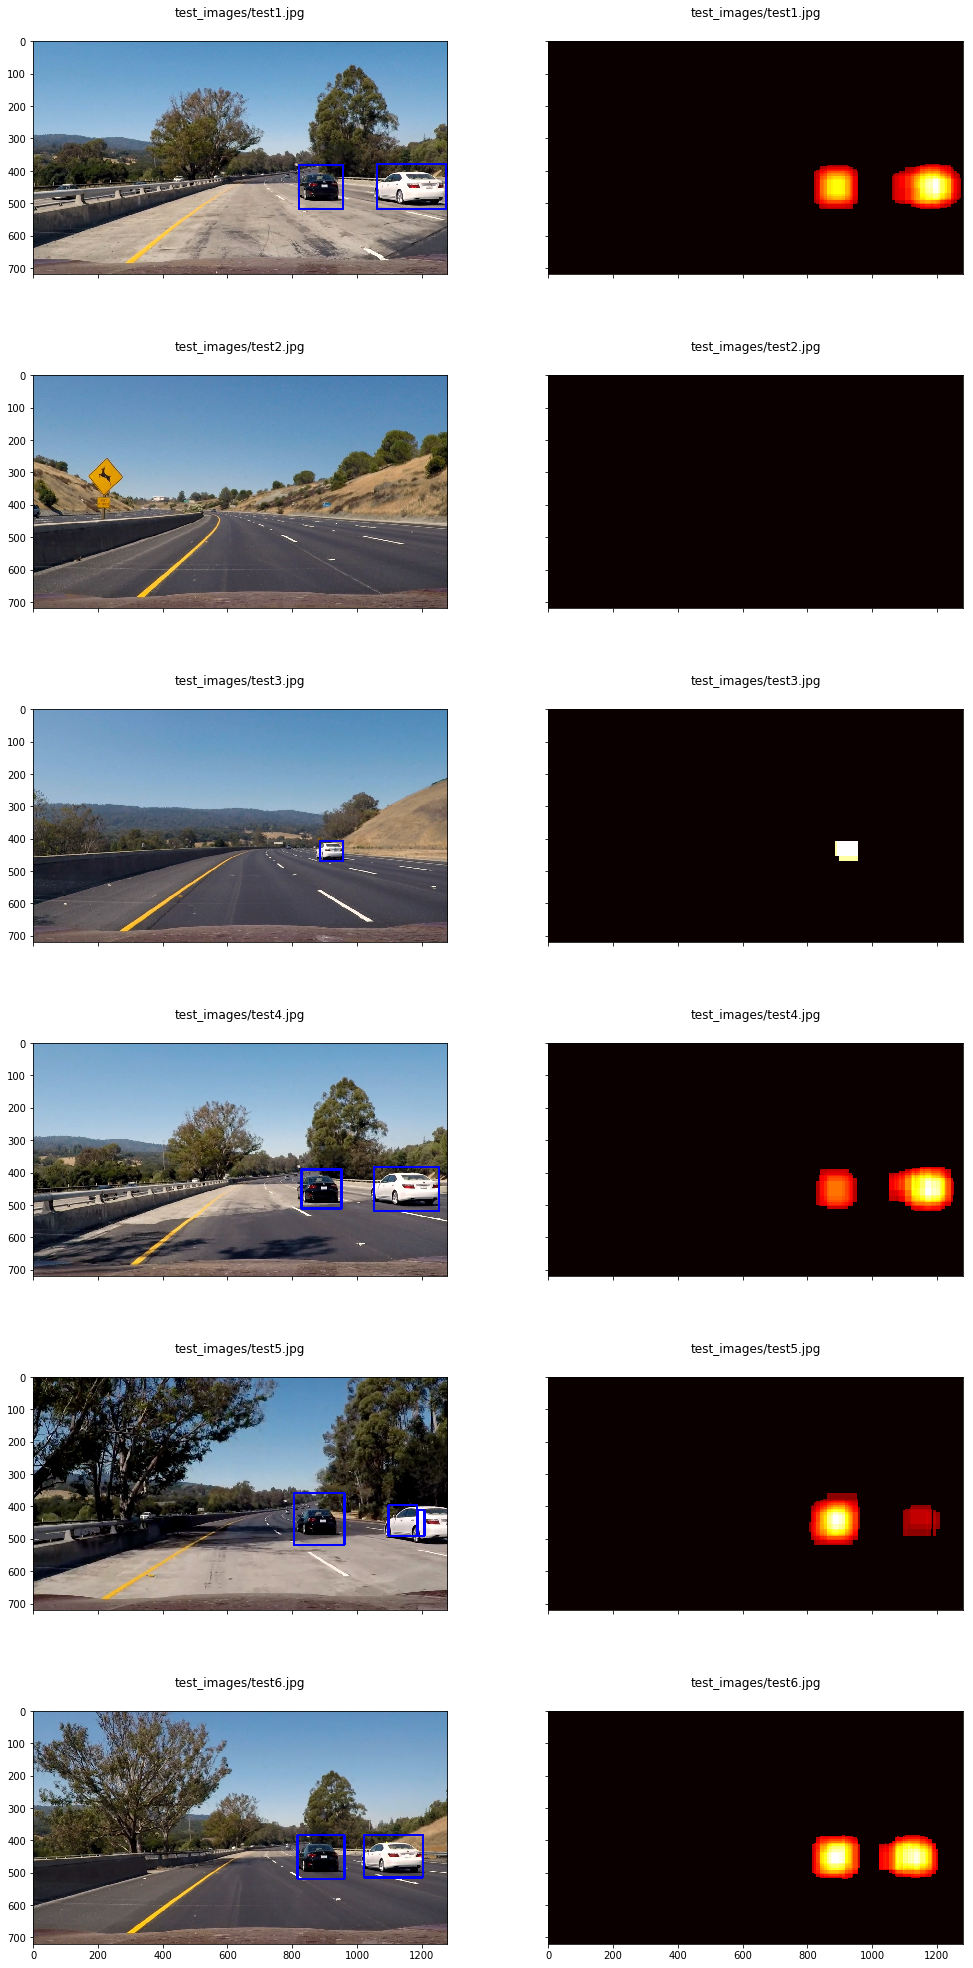

In [9]:
figure = plt.figure(1, (35., 35.))
rows = 6
cols = 2
i = 0
j = 0
image_grid = ImageGrid(figure, 111, nrows_ncols=(rows, cols), axes_pad=1.4)

for fname in images:
    img = mpimg.imread(fname)
    
    heatmap,standard = heatmap_box(img)
    
    image_grid[i].set_title(fname, y=1.08)
    image_grid[i].imshow(standard)
    
    image_grid[i+1].set_title(fname, y=1.08)
    image_grid[i+1].imshow(heatmap,cmap='hot')
    i = i + 2
    
plt.show()

## Video Export

At this point we have a reasonable result that can be overlayed on a video.

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

def process_image(image):
    heatmap,standard = heatmap_box(image)
    
    return standard

visual_output = 'output_images/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
output_clip=clip1.fl_image(process_image)
%time output_clip.write_videofile(visual_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4



 12%|█▏        | 149/1261 [07:42<56:07,  3.03s/it]


 24%|██▍       | 300/1261 [15:34<51:24,  3.21s/it]


 36%|███▌      | 451/1261 [23:28<40:43,  3.02s/it]


 48%|████▊     | 602/1261 [30:54<30:35,  2.79s/it]


 60%|█████▉    | 753/1261 [37:58<23:39,  2.79s/it]


 72%|███████▏  | 904/1261 [45:10<19:36,  3.30s/it]


 84%|████████▎ | 1054/1261 [52:30<09:49,  2.85s/it]


 95%|█████████▌| 1202/1261 [59:41<02:44,  2.79s/it]


 99%|█████████▉| 1247/1261 [1:01:48<00:39,  2.79s/it]